In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *
from strategies import *
from metrics import *
import universal as up
from universal import tools, algos
from universal.result import AlgoResult, ListResult

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

In [2]:
def run(paras, strategy_lst, figsize=(10,5), phase_cnt=12):
    maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

    results = []
    concat_result_dict = {}
    for phs in range(0, phase_cnt):
        print('Phase %d' % phs)
        data_path1 = './stock_data/MSCI_stock_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path1, allow_pickle=True)
        subn = min(subn, data['rt_trainy'].shape[1])
        cov_train, choice = data['cov_train'], data['choice']
        if paras['inverse']:
            choice = choice[::-1]
        cov = cov_train[choice[:subn], :][:, choice[:subn]]
#         w, v = np.linalg.eig(cov)
#         print(w)

        print('Testing...')
        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        
#         strategy_lst = ['ucb_strategy(0, predY0, std_varY0, sample_Y0)', 
#                         'opt_strategy(predY0, std_var_Y0, sample_Y0, cov, paras["opt_delta"])', 
#                         'passive_strategy(predY0, std_var_Y0, sample_Y0, cov, paras["passive_eps"], paras["passive_delta"])']
#         metrics_lst =['cumulative_return(rt_v)', 'daily_return(rt_v)', 'max_redraw(rt_v)']
        
        result_dict = {}        
        for strategy in strategy_lst:
            strategy_name = strategy.split('(')[0]
            print(strategy_name)
            rt_v, x_vec = eval(strategy)
            result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [exp(sample_Y0.copy())]]
            if strategy_name in concat_result_dict:
                concat_result_dict[strategy_name][0] += rt_v.copy()
                concat_result_dict[strategy_name][1] += x_vec.copy()
                concat_result_dict[strategy_name][2] += [exp(sample_Y0).copy()]
            else:
                concat_result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [exp(sample_Y0).copy()]]
#             for metric in metrics_lst:
#                 metric_name = metric.split('(')[0]     
#                 res = eval(metric)
#                 print('\t%s: %.8f' % (metric_name, res))
        results.append(result_dict)
                
#     print()
#     print('===========================overall results===========================')
#     for strategy in strategy_lst:
#         strategy_name = strategy.split('(')[0]
#         print(strategy_name)
#         rt_v, x_vec = concat_result_dict[strategy_name]
#         for metric in metrics_lst:
#             metric_name = metric.split('(')[0]     
#             res = eval(metric)
#             print('\t%s: %.8f' % (metric_name, res))

    return results, concat_result_dict

In [3]:
def display(strategy_name, concat_results, paras, figsize=(10,5)):
    rt_v, x_vec, sample_Y0 = concat_results[strategy_name]
    B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
    B = pd.DataFrame(B)
    Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
    result = AlgoResult(Y, B)
    result.set_rf_rate(paras['rf'])
    print('========================================================')
    print(strategy_name)
    print('--------------------------------------------------------')
    print('fee = 0')
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.001
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.0025
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.005
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure()
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print()

In [4]:
def display_phs(strategy_name, results, phs, paras, figsize=(10,5)):
    print('========================================================')
    print('Phase %d'%phs)
    for strategy in strategy_lst:
        strategy_name = strategy.split('(')[0]
        rt_v, x_vec, sample_Y0 = results[phs][strategy_name]
        
        B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
        B = pd.DataFrame(B)
        Y = pd.DataFrame(sample_Y0[0])
#         print(B.shape)
#         print(Y.shape)
        result = AlgoResult(Y, B)
        result.set_rf_rate(paras['rf'])
        print(strategy_name)
        print('--------------------------------------------------------')
        print('fee = 0')
        print(result.summary())
        print('Total wealth:', result.total_wealth)

In [5]:
strategy_lst = ['ucb_strategy(0, predY0, std_varY0, sample_Y0)', 
                'opt_strategy(predY0, std_varY0, sample_Y0, cov, paras["opt_gamma"])', 
                'passive_strategy2(predY0, std_varY0, sample_Y0, cov, paras["passive_eps"], paras["passive_gamma"])'
               ]

# Pearson 

## Pearson 0.95 + GGD

In [116]:
paras={'dataset':'MSCI', 'maxiter':2000, 'subn':100, 'lb':5, 'M':10, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'opt_gamma':10, 'passive_eps':0.9996, 'passive_gamma':10.0,
       'mattype':-1, 'dg':0.95
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=7)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy2
No opt solution
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy2


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 0.95
    Sharpe ratio: -0.15 ± 0.60
    Ulcer index: -0.14
    Information ratio (wrt UCRP): 0.88
    Appraisal ratio (wrt UCRP): 0.68 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.98 / 5.179%
    Annualized return: -8.24%
    Annualized volatility: 29.17%
    Longest drawdown: 587 days
    Max drawdown: 60.97%
    Winning days: 51.3%
    Annual turnover: 235.0
        
Total wealth: 0.7875657102285334


<Figure size 720x360 with 0 Axes>

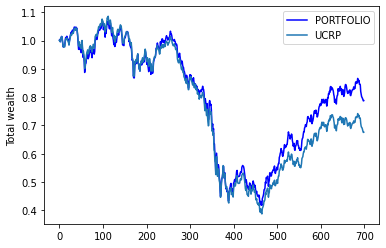

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.82
    Sharpe ratio: -0.96 ± 0.72
    Ulcer index: -0.59
    Information ratio (wrt UCRP): -2.95
    Appraisal ratio (wrt UCRP): -2.39 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.98 / -18.340%
    Annualized return: -27.46%
    Annualized volatility: 29.13%
    Longest drawdown: 665 days
    Max drawdown: 73.71%
    Winning days: 48.1%
    Annual turnover: 235.0
        
Total wealth: 0.40985967207757235


<Figure size 720x360 with 0 Axes>

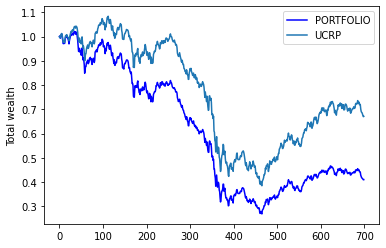

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.66
    Sharpe ratio: -2.17 ± 1.10
    Ulcer index: -0.99
    Information ratio (wrt UCRP): -8.55
    Appraisal ratio (wrt UCRP): -6.89 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.97 / -53.618%
    Annualized return: -49.05%
    Annualized volatility: 29.08%
    Longest drawdown: 694 days
    Max drawdown: 86.22%
    Winning days: 45.3%
    Annual turnover: 235.0
        
Total wealth: 0.15367796466390068


<Figure size 720x360 with 0 Axes>

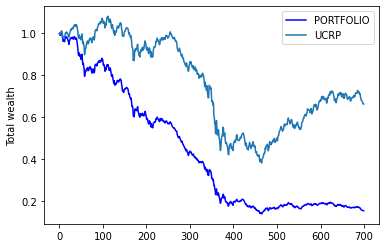

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.46
    Sharpe ratio: -4.20 ± 1.88
    Ulcer index: -1.57
    Information ratio (wrt UCRP): -17.03
    Appraisal ratio (wrt UCRP): -13.87 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.97 / -112.414%
    Annualized return: -71.75%
    Annualized volatility: 29.03%
    Longest drawdown: 698 days
    Max drawdown: 97.01%
    Winning days: 38.7%
    Annual turnover: 235.0
        
Total wealth: 0.02986141962622004


<Figure size 432x288 with 0 Axes>

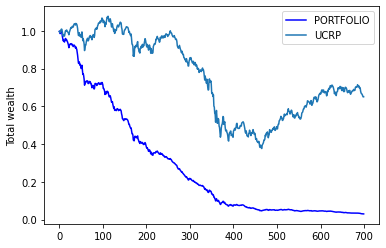


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.00
    Sharpe ratio: 0.13 ± 0.60
    Ulcer index: 0.14
    Information ratio (wrt UCRP): 1.22
    Appraisal ratio (wrt UCRP): 1.02 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.90 / 12.572%
    Annualized return: -0.22%
    Annualized volatility: 28.40%
    Longest drawdown: 444 days
    Max drawdown: 59.93%
    Winning days: 51.9%
    Annual turnover: 320.6
        
Total wealth: 0.9939644104527754


<Figure size 720x360 with 0 Axes>

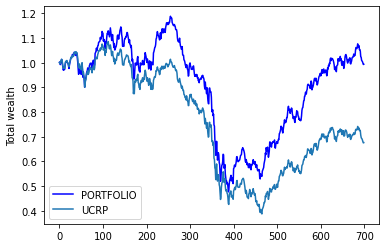

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.81
    Sharpe ratio: -1.00 ± 0.73
    Ulcer index: -0.60
    Information ratio (wrt UCRP): -1.66
    Appraisal ratio (wrt UCRP): -1.58 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.90 / -19.500%
    Annualized return: -27.59%
    Annualized volatility: 28.34%
    Longest drawdown: 694 days
    Max drawdown: 72.21%
    Winning days: 48.7%
    Annual turnover: 320.6
        
Total wealth: 0.4079750573670563


<Figure size 720x360 with 0 Axes>

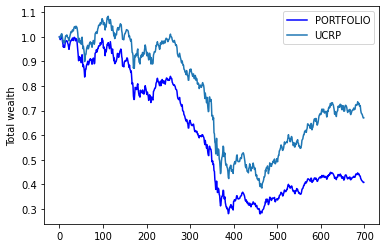

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.60
    Sharpe ratio: -2.70 ± 1.29
    Ulcer index: -1.11
    Information ratio (wrt UCRP): -5.93
    Appraisal ratio (wrt UCRP): -5.46 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.89 / -67.607%
    Annualized return: -55.27%
    Annualized volatility: 28.27%
    Longest drawdown: 699 days
    Max drawdown: 89.30%
    Winning days: 42.4%
    Annual turnover: 320.6
        
Total wealth: 0.10703404428674491


<Figure size 720x360 with 0 Axes>

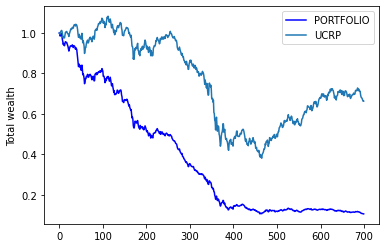

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.36
    Sharpe ratio: -5.55 ± 2.43
    Ulcer index: -1.89
    Information ratio (wrt UCRP): -12.73
    Appraisal ratio (wrt UCRP): -11.69 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.89 / -147.786%
    Annualized return: -80.00%
    Annualized volatility: 28.22%
    Longest drawdown: 699 days
    Max drawdown: 98.85%
    Winning days: 32.6%
    Annual turnover: 320.6
        
Total wealth: 0.01143686378893159


<Figure size 432x288 with 0 Axes>

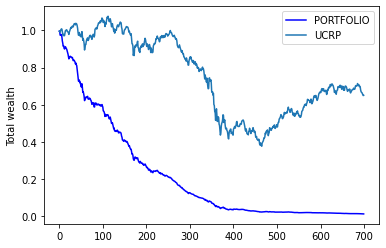


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 0.93
    Sharpe ratio: -0.26 ± 0.61
    Ulcer index: -0.21
    Information ratio (wrt UCRP): 0.41
    Appraisal ratio (wrt UCRP): 0.23 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.87 / 1.840%
    Annualized return: -9.64%
    Annualized volatility: 26.35%
    Longest drawdown: 587 days
    Max drawdown: 58.71%
    Winning days: 50.7%
    Annual turnover: 13.6
        
Total wealth: 0.7544969047692349


<Figure size 720x360 with 0 Axes>

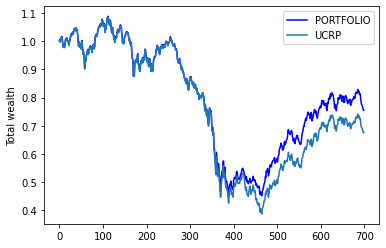

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.92
    Sharpe ratio: -0.31 ± 0.61
    Ulcer index: -0.25
    Information ratio (wrt UCRP): 0.22
    Appraisal ratio (wrt UCRP): 0.05 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.87 / 0.422%
    Annualized return: -10.90%
    Annualized volatility: 26.32%
    Longest drawdown: 587 days
    Max drawdown: 59.34%
    Winning days: 50.6%
    Annual turnover: 13.6
        
Total wealth: 0.7257367878713573


<Figure size 720x360 with 0 Axes>

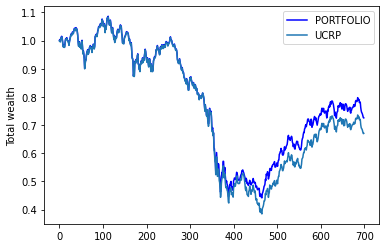

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.91
    Sharpe ratio: -0.39 ± 0.62
    Ulcer index: -0.30
    Information ratio (wrt UCRP): -0.06
    Appraisal ratio (wrt UCRP): -0.21 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.87 / -1.705%
    Annualized return: -12.75%
    Annualized volatility: 26.27%
    Longest drawdown: 587 days
    Max drawdown: 60.54%
    Winning days: 50.3%
    Annual turnover: 13.6
        
Total wealth: 0.6846134613485084


<Figure size 720x360 with 0 Axes>

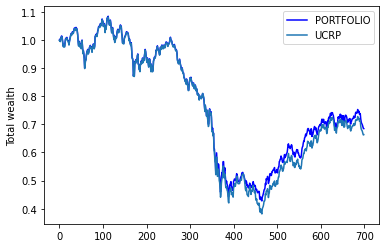

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.89
    Sharpe ratio: -0.53 ± 0.64
    Ulcer index: -0.38
    Information ratio (wrt UCRP): -0.51
    Appraisal ratio (wrt UCRP): -0.64 ± 0.60
    UCRP sharpe: -0.34 ± 0.62
    Beta / Alpha: 0.87 / -5.250%
    Annualized return: -15.75%
    Annualized volatility: 26.21%
    Longest drawdown: 587 days
    Max drawdown: 62.45%
    Winning days: 49.3%
    Annual turnover: 13.6
        
Total wealth: 0.6211253059508908


<Figure size 432x288 with 0 Axes>

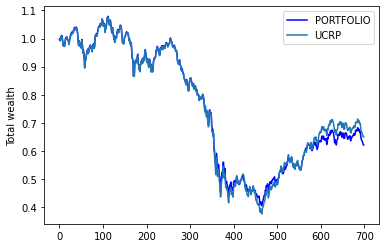

In [117]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)